In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def lerarquivos(mes):
     #Caminho do arquivo CSV
    url = f"../dados-tratados/pc-{mes:0>2}.csv"

    # Carregando o dataset
    return pd.read_csv(url, sep=";")

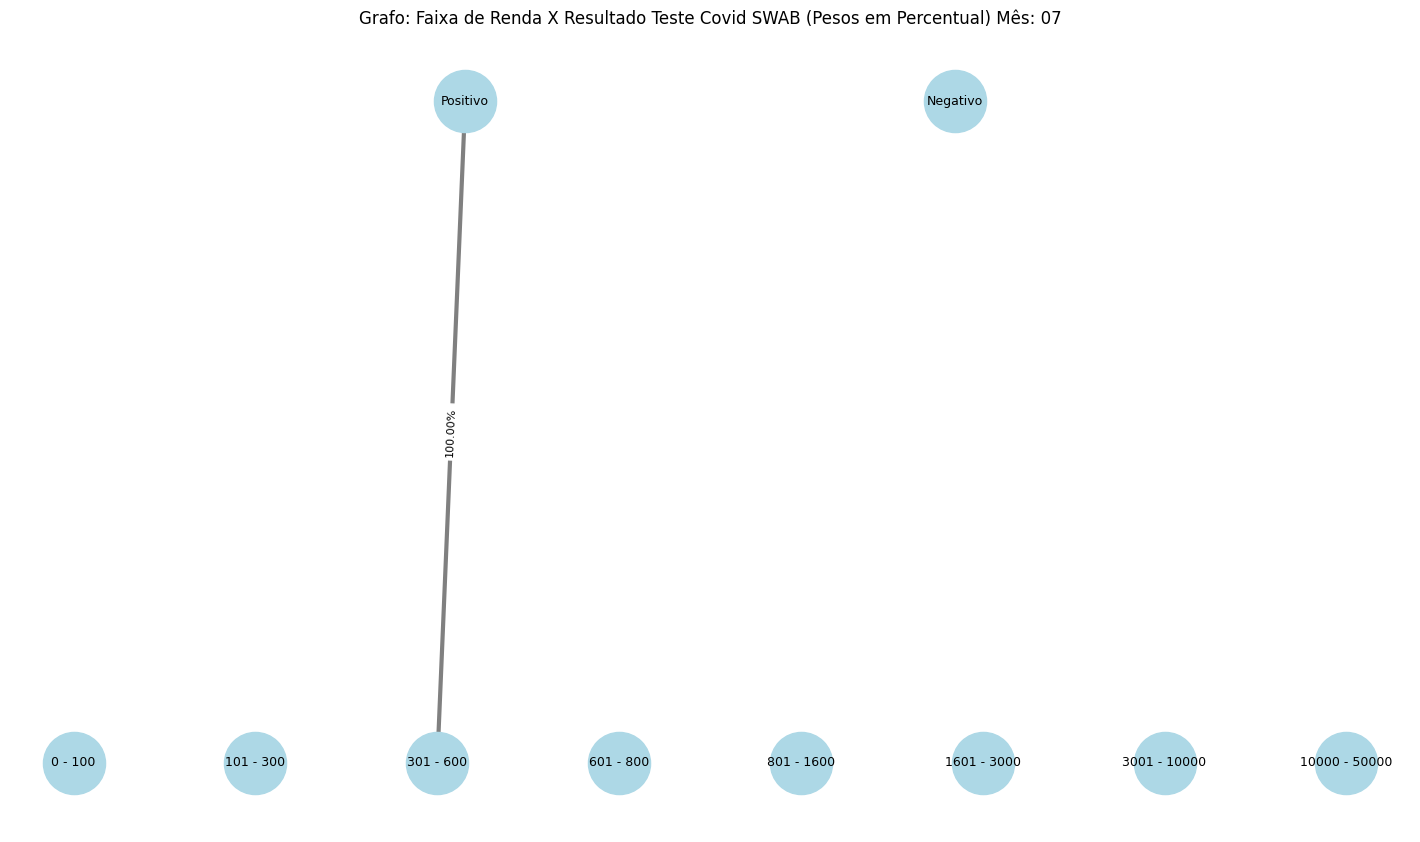

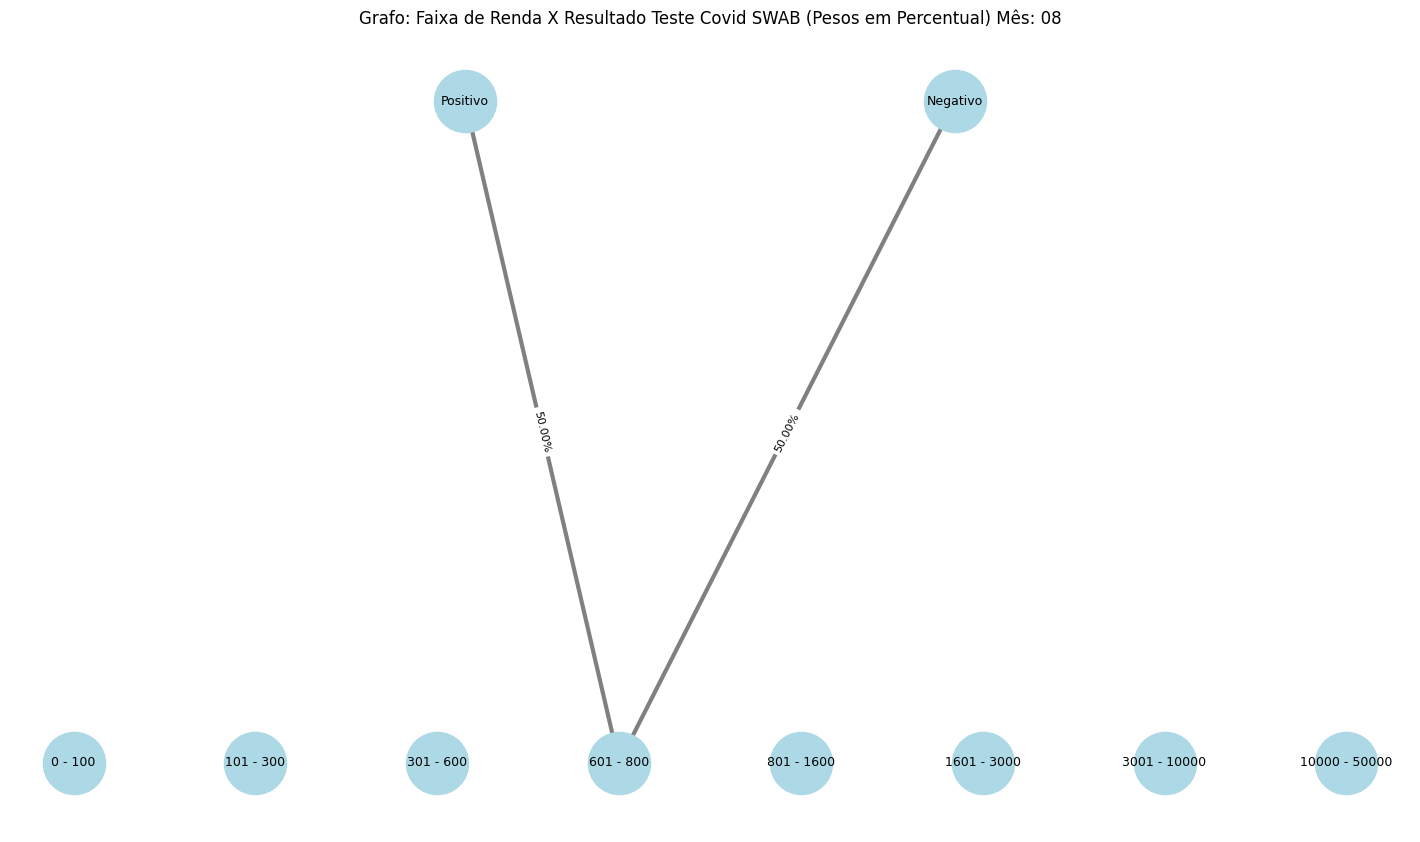

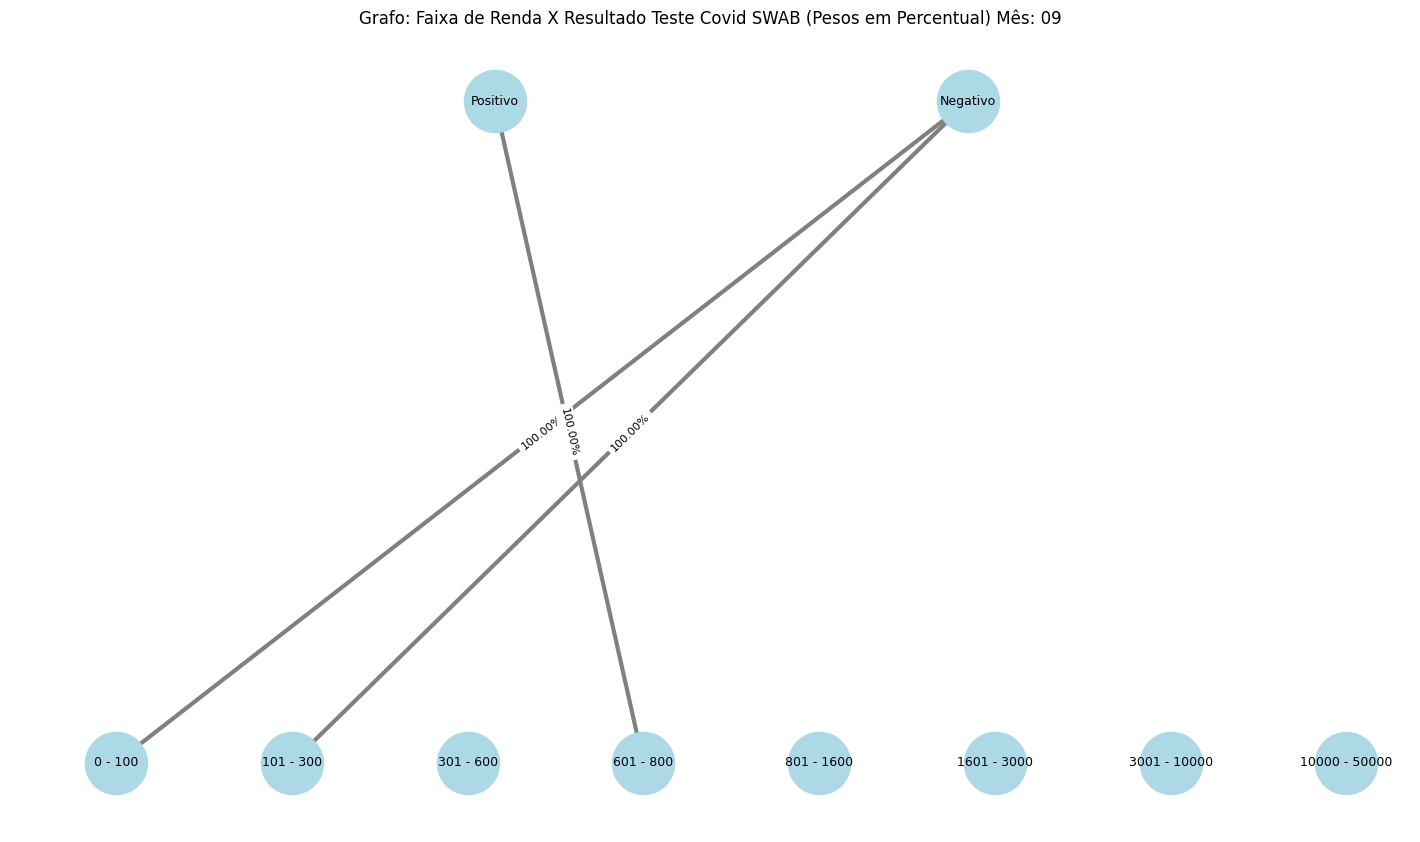

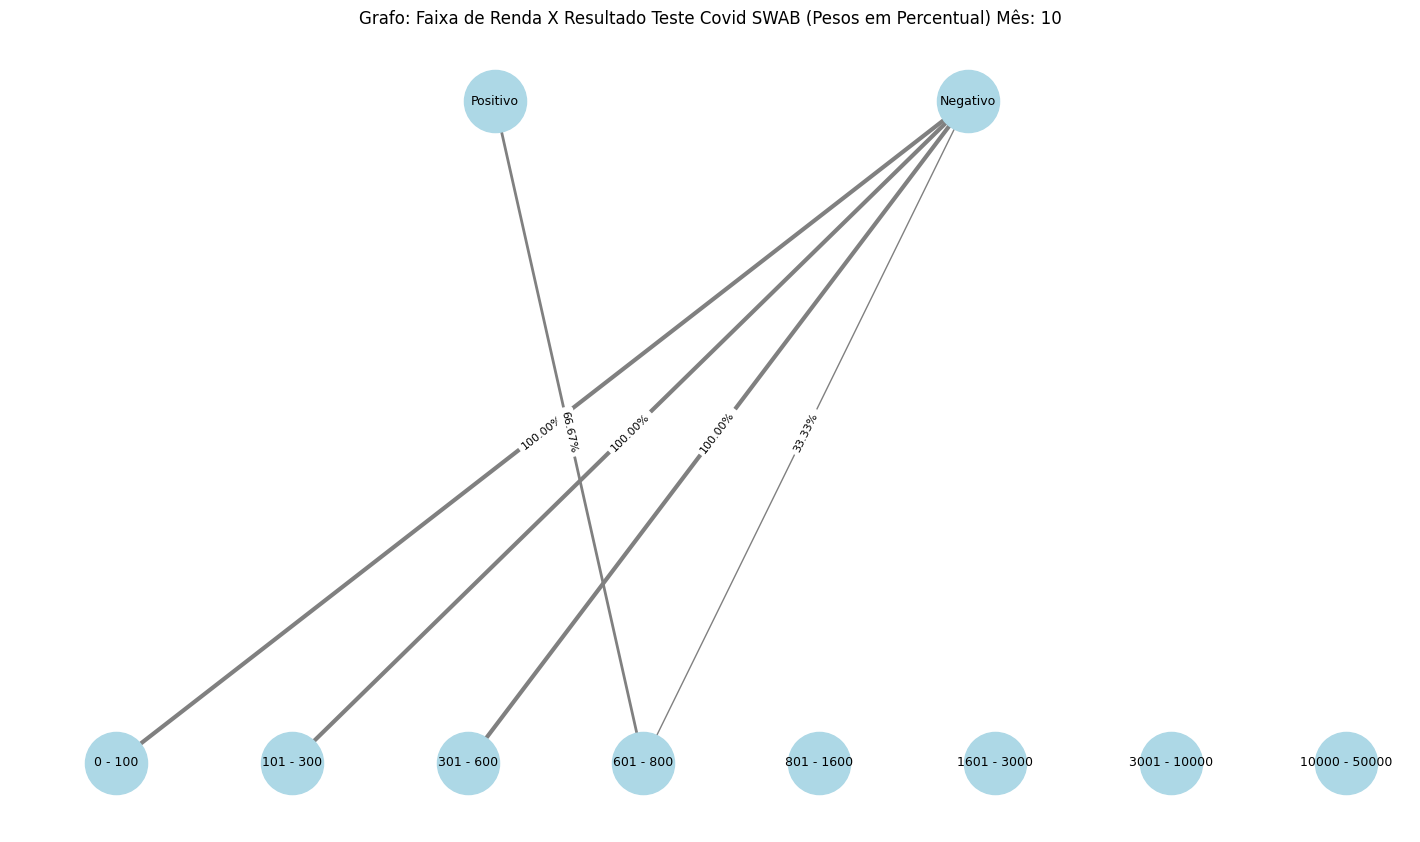

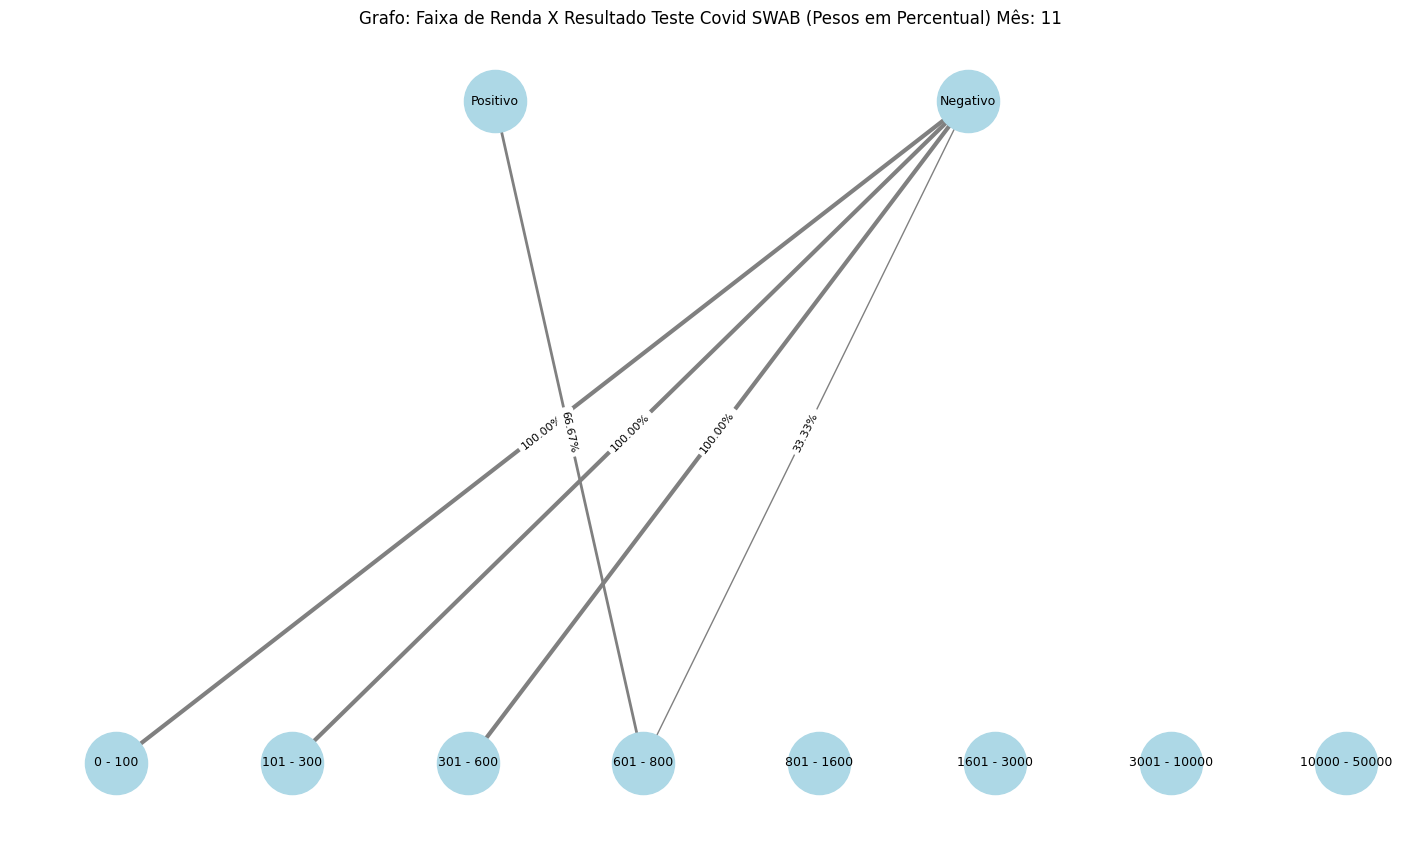

In [3]:
# Definindo as faixas de renda e os resultados de teste
faixas_renda = [
    "0 - 100", "101 - 300", "301 - 600", "601 - 800",
    "801 - 1600", "1601 - 3000", "3001 - 10000", "10000 - 50000"
]
resultado_teste = [
    "Positivo", "Negativo"
]

# Loop para os meses (ajuste conforme necessário)
for m in range(7, 12):
    df = lerarquivos(m)

    # Preenchendo NaN nas colunas de Faixa_renda e Resultado_teste e filtrando
    faixa_renda_coluna = "Faixa_renda"
    resultado_coluna = "Resultado_SWAB"
    df[faixa_renda_coluna] = df[faixa_renda_coluna].fillna("Ignorado")  # Preencher valores faltantes com "Ignorado"
    #df[resultado_coluna] = df[resultado_coluna].fillna("Ignorado").str.strip()  # Preencher e remover espaços extras
    df = df[df[faixa_renda_coluna].isin(faixas_renda)]  # Filtrando as faixas de renda válidas
    df = df[df[resultado_coluna].isin(resultado_teste)]  # Filtrando os valores válidos para Resultado_teste

    # Criando o grafo
    G = nx.Graph()

    # Adicionando os nós de Faixa_renda à parte superior e Resultado_teste à parte inferior
    G.add_nodes_from(faixas_renda, bipartite=0)  # Faixas de renda na parte superior
    G.add_nodes_from(resultado_teste, bipartite=1)  # Resultado do teste na parte inferior

    # Contagem de pessoas por faixa de renda
    total_por_faixa_renda = df[faixa_renda_coluna].value_counts().to_dict()

    # Calculando as arestas entre Faixa_renda e Resultado_teste
    pesos = {}

    for _, row in df.iterrows():
        faixa_renda = row[faixa_renda_coluna]
        resultado = row[resultado_coluna]
        peso = 1  # A cada valor de Resultado_teste, adiciona 1

        # Se a aresta já existe, soma o peso
        if (faixa_renda, resultado) in pesos:
            pesos[(faixa_renda, resultado)] += peso
        else:
            pesos[(faixa_renda, resultado)] = peso

    # Calculando os pesos percentuais das arestas em relação à quantidade de pessoas na faixa de renda
    pesos_percentuais = {}

    # Cálculo dos totais por faixa de renda para a porcentagem
    totais_por_faixa_renda = {faixa: total_por_faixa_renda.get(faixa, 0) for faixa in faixas_renda}

    # Ajustando os pesos percentuais por faixa de renda
    for (faixa_renda, resultado), peso in pesos.items():
        total_faixa = totais_por_faixa_renda.get(faixa_renda, 0)
        porcentagem = (peso / total_faixa) * 100 if total_faixa > 0 else 0
        pesos_percentuais[(faixa_renda, resultado)] = porcentagem

    # Adicionando as arestas ao grafo com os pesos em percentual
    for (u, v), peso in pesos_percentuais.items():
        G.add_edge(u, v, weight=peso)

    # Definindo a posição dos nós (faixas de renda na parte superior, resultado teste na parte inferior)
    pos = {}

    # Posicionando as faixas de renda na parte superior com espaçamento uniforme
    faixa_x = np.linspace(-2, 11, len(faixas_renda))  # Espaçamento uniforme ao longo do eixo X
    for i, (faixa, x) in enumerate(zip(faixas_renda, faixa_x)):
        pos[faixa] = (x, 0)  # Faixas de renda na parte superior

    # Posicionando os resultados de teste na parte inferior com espaçamento uniforme
    resultado_x = np.linspace(2, 7, len(resultado_teste))  # Espaçamento uniforme
    for i, (resultado, x) in enumerate(zip(resultado_teste, resultado_x)):
        pos[resultado] = (x, 1)  # Resultados de teste na parte inferior

    # Extrair os pesos das arestas para ajustar a espessura
    edges = G.edges(data=True)
    max_peso = max(pesos_percentuais.values()) if pesos_percentuais else 1  # Evitar divisão por zero
    weights = [edata["weight"] / max_peso * 3 for _, _, edata in edges]  # Ajuste de espessura

    # Rótulos nas arestas com as porcentagens
    edge_labels = {(u, v): f"{d['weight']:.2f}%" for u, v, d in G.edges(data=True)}

    # Plotando o grafo
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray", width=weights, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Grafo: Faixa de Renda X Resultado Teste Covid SWAB (Pesos em Percentual) Mês: {m:02}")
    plt.show()